In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import cv2
import torch
from tqdm import tqdm_notebook
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
def kaggle_commit_logger(str_to_log, need_print = True):
    if need_print:
        print(str_to_log)
    os.system('echo ' + str_to_log)

In [3]:
SEED = 42

In [4]:
IMG_SIZE = 256

In [5]:
torch.manual_seed(SEED)
np.random.seed(0)

In [6]:
KAGGLE_INPUT_DIR = '/kaggle/input/'

IMET_DIRNAME = 'imet-2019-fgvc6'
PYTORCH_PRETRAIED_WEIGHTS_DIRNAME = 'pretrained-pytorch-models'

TEST_DIR = 'test'
TRAIN_DIR = 'train'

SAMPLE_SUBMISSION_FILENAME = 'sample_submission.csv'
TRAIN_ANS_FILENAME = 'train.csv'

IMG_EXTENSION = '.png'

In [7]:
TRAIN_IMGS_DIR = os.path.join(KAGGLE_INPUT_DIR, IMET_DIRNAME, TRAIN_DIR)
TEST_IMGS_DIR = os.path.join(KAGGLE_INPUT_DIR, IMET_DIRNAME, TEST_DIR)

In [8]:
ID_COLNAME = 'id'
ANSWER_COLNAME = 'attribute_ids'

In [9]:
os.environ['TORCH_MODEL_ZOO'] = os.path.join(KAGGLE_INPUT_DIR, PYTORCH_PRETRAIED_WEIGHTS_DIRNAME)

In [10]:
sample_sumbission_filepath = os.path.join(KAGGLE_INPUT_DIR,
                                          IMET_DIRNAME, SAMPLE_SUBMISSION_FILENAME)
train_ans_filepath = os.path.join(KAGGLE_INPUT_DIR, IMET_DIRNAME, TRAIN_ANS_FILENAME)

In [11]:
TRAIN_ANS_DF = pd.read_csv(train_ans_filepath)

In [12]:
SAMPLE_SUBMISSION_DF = pd.read_csv(sample_sumbission_filepath)

In [13]:
flatten = lambda l: [item for sublist in l for item in sublist]

def get_flatten_labels(series: pd.Series):
    flatten_vals = flatten(series.apply(lambda x: x.split(' ')))
    return pd.Series(flatten_vals).value_counts()

In [14]:
train_labels_vc = get_flatten_labels(TRAIN_ANS_DF[ANSWER_COLNAME])

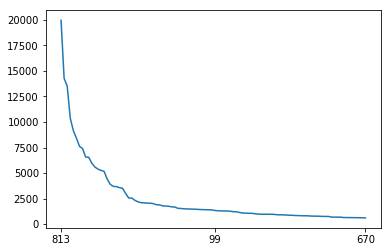

In [15]:
plt.plot(train_labels_vc[:100]);
plt.xticks([0, 50, 99]);

In [16]:
N_PICS_TH_TO_USE = 250

CLASSES_TO_USE = list(train_labels_vc[train_labels_vc > N_PICS_TH_TO_USE].index)
NUM_FIXED_CLASSES = len(CLASSES_TO_USE)
print(NUM_FIXED_CLASSES)

208


In [17]:
OLD_NEW_CLASSMAP = dict(
    [(i, j) for i, j
     in zip(CLASSES_TO_USE, range(NUM_FIXED_CLASSES))
    ]
)

In [18]:
REVERSE_CLASSMAP = dict([(v, k) for k, v in OLD_NEW_CLASSMAP.items()])

In [19]:
def delete_rare_labels(base_labels_str: str, classes_to_use = CLASSES_TO_USE):
    set_of_classes = set(base_labels_str.split(' '))
    return_list = list(set_of_classes.intersection(set(classes_to_use)))
    return ' '.join(
        [str(i)
         for i in
         sorted([int(i) for i in return_list])
        ]
    )

In [20]:
FIXED_ANSWER_COLNAME = 'fixed_attribute_ids'

TRAIN_ANS_DF[FIXED_ANSWER_COLNAME] = TRAIN_ANS_DF[ANSWER_COLNAME].map(delete_rare_labels)

In [21]:
model = models.resnet18(pretrained='imagenet')

In [22]:
new_head = torch.nn.Linear(model.fc.in_features, NUM_FIXED_CLASSES)
model.fc = new_head

In [23]:
model.cuda();

In [24]:
TRAIN_ANS_DF = TRAIN_ANS_DF[TRAIN_ANS_DF[FIXED_ANSWER_COLNAME] != '']

In [25]:
TEST_SIZE = 0.15

train_df, test_df = train_test_split(TRAIN_ANS_DF[[ID_COLNAME, FIXED_ANSWER_COLNAME]],
                                     test_size = TEST_SIZE,
                                     random_state = SEED,
                                     shuffle = True
                                    )

In [26]:
from torchvision import transforms

In [27]:
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_augmentation = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(13),
    transforms.ToTensor(),
    normalizer,
])

val_augmentation = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    normalizer,
])

In [28]:
class IMetDataset(Dataset):
    
    def __init__(self,
                 df,
                 images_dir,
                 n_classes = NUM_FIXED_CLASSES,
                 id_colname = ID_COLNAME,
                 answer_colname = FIXED_ANSWER_COLNAME,
                 img_ext = IMG_EXTENSION,
                 label_to_network_id_dict = OLD_NEW_CLASSMAP,
                 transforms = None
                ):
        self.df = df
        self.images_dir = images_dir
        self.n_classes = n_classes
        self.id_colname = id_colname
        self.answer_colname = answer_colname
        self.img_ext = img_ext
        self.label_to_network_id_dict = label_to_network_id_dict
        self.transforms = transforms
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        cur_idx_row = self.df.iloc[idx]
        img_id = cur_idx_row[self.id_colname]
        img_name = img_id + self.img_ext
        img_path = os.path.join(self.images_dir, img_name)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        if self.answer_colname is not None:
            labels_list = cur_idx_row[self.answer_colname].split(' ')
            updated_ids = [self.label_to_network_id_dict[cur_ans]
                           for cur_ans in labels_list]

            FILLVAL = 1.0
            label = torch.zeros((self.n_classes,), dtype=torch.float32)

            for cur_idx_to_repair in updated_ids:
                label[cur_idx_to_repair] = FILLVAL

            return img, label
        
        else:
            return img, img_id

In [29]:
train_dataset = IMetDataset(train_df, TRAIN_IMGS_DIR, transforms = train_augmentation)
test_dataset = IMetDataset(test_df, TRAIN_IMGS_DIR, transforms = val_augmentation)

In [30]:
BS = 24


train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=2, pin_memory=True)
# train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, pin_memory=True)

In [31]:
#plt.figure(figsize=(15,8));
#plt.imshow(train_dataset[92851 - 322][0]);

In [32]:
def cuda(x):
    return x.cuda(non_blocking=True)

In [33]:
# from https://www.kaggle.com/igormq/f-beta-score-for-pytorch

def f2_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 2, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

In [34]:
def train_one_epoch(model, train_loader, criterion, optimizer, steps_upd_logging = 250):
    model.train();
    
    total_loss = 0.0
    
    train_tqdm = tqdm_notebook(train_loader)
    
    for step, (features, targets) in enumerate(train_tqdm):
        features, targets = cuda(features), cuda(targets)
        
        optimizer.zero_grad()
        
        logits = model(features)
        
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (step + 1) % steps_upd_logging == 0:
            logstr = f'Train loss on step {step + 1} was {round(total_loss / (step + 1), 5)}'
            train_tqdm.set_description(logstr)
            kaggle_commit_logger(logstr, need_print=False)
        
    return total_loss / (step + 1)

In [35]:
def validate(model, valid_loader, criterion, need_tqdm = False):
    model.eval();
    
    test_loss = 0.0
    TH_TO_ACC = 0.5
    
    true_ans_list = []
    preds_cat = []
    
    with torch.no_grad():
        
        if need_tqdm:
            valid_iterator = tqdm_notebook(valid_loader)
        else:
            valid_iterator = valid_loader
        
        for step, (features, targets) in enumerate(valid_iterator):
            features, targets = cuda(features), cuda(targets)

            logits = model(features)
            loss = criterion(logits, targets)

            test_loss += loss.item()
            true_ans_list.append(targets)
            preds_cat.append(torch.sigmoid(logits))

        all_true_ans = torch.cat(true_ans_list)
        all_preds = torch.cat(preds_cat)
        
        f2_eval = f2_score(all_true_ans, all_preds).item()

    logstr = f'Mean val f2: {round(f2_eval, 5)}'
    kaggle_commit_logger(logstr)
    return test_loss / (step + 1), f2_eval

In [36]:
criterion = torch.nn.BCEWithLogitsLoss()
# TODO: LRFinder and OneCycle implementation
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

In [37]:
N_EPOCHS = 20
TRAIN_LOGGING_EACH = 500

train_losses = []
valid_losses = []
valid_f2s = []

best_model_f2 = 0.0
best_model = None
best_model_ep = 0

for epoch in range(1, N_EPOCHS + 1):
    ep_logstr = f"Starting {epoch} epoch..."
    kaggle_commit_logger(ep_logstr)
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, TRAIN_LOGGING_EACH)
    train_losses.append(tr_loss)
    tr_loss_logstr = f'Mean train loss: {round(tr_loss,5)}'
    kaggle_commit_logger(tr_loss_logstr)
    
    valid_loss, valid_f2 = validate(model, test_loader, criterion)
    valid_losses.append(valid_loss)
    valid_f2s.append(valid_f2)
    val_loss_logstr = f'Mean valid loss: {round(valid_loss,5)}'
    kaggle_commit_logger(val_loss_logstr)
    sheduler.step(valid_loss)
    
    if valid_f2 >= best_model_f2:
        best_model = model
        best_model_f2 = valid_f2
        best_model_ep = epoch

Starting 1 epoch...



Mean train loss: 0.05437
Mean val f2: 0.06627
Mean valid loss: 0.05005
Starting 2 epoch...



Mean train loss: 0.04709
Mean val f2: 0.1648
Mean valid loss: 0.04496


In [38]:
bestmodel_logstr = f'Best f2 is {round(best_model_f2, 5)} on epoch {best_model_ep}'
kaggle_commit_logger(bestmodel_logstr)

Best f2 is 0.1648 on epoch 2


In [ ]:
# import gc
# del  train_loader, test_loader, train_dataset, test_dataset
# del train_df, test_df
# gc.collect()

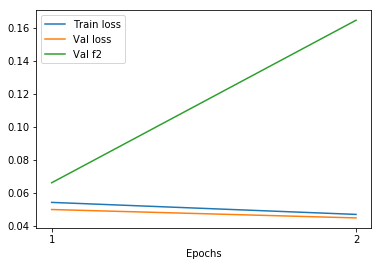

In [39]:
xs = list(range(1, len(train_losses) + 1))

plt.plot(xs, train_losses, label = 'Train loss');
plt.plot(xs, valid_losses, label = 'Val loss');
plt.plot(xs, valid_f2s, label = 'Val f2');
plt.legend();
plt.xticks(xs);
plt.xlabel('Epochs');

In [40]:
subm_dataset = IMetDataset(SAMPLE_SUBMISSION_DF,
                           TEST_IMGS_DIR,
                           transforms = val_augmentation,
                           answer_colname=None
                          )

In [41]:
SUMB_BS = 48

subm_dataloader = DataLoader(subm_dataset,
                             batch_size=SUMB_BS,
                             shuffle=False,
                             pin_memory=True)

In [42]:
def get_subm_answers(model, subm_dataloader, TH = 0.5, need_tqdm = False):
    model.eval();
    preds_cat = []
    ids = []
    
    with torch.no_grad():
        
        if need_tqdm:
            subm_iterator = tqdm_notebook(subm_dataloader)
        else:
            subm_iterator = subm_dataloader
        
        for step, (features, subm_ids) in enumerate(subm_iterator):
            features = cuda(features)

            logits = model(features)
            preds_cat.append(torch.sigmoid(logits))
            ids += subm_ids

        all_preds = torch.cat(preds_cat)
        all_preds = torch.ge(all_preds, TH).int().cpu().numpy()
    return all_preds, ids

In [43]:
best_model.cuda();

subm_preds, submids = get_subm_answers(best_model, subm_dataloader, 0.5, True)

In [44]:
ans_dict = dict([cur_id, ''] for cur_id in submids)

nonzero_idx, nonzero_classes = np.nonzero(subm_preds)

for cur_id, cur_class in zip(np.array(submids)[nonzero_idx],
                            nonzero_classes):
    ans_dict[cur_id] += str(cur_class) + ' '


In [45]:
df_to_process = (
    pd.DataFrame
    .from_dict(ans_dict, orient='index', columns=[ANSWER_COLNAME])
    .reset_index()
    .rename({'index':ID_COLNAME}, axis=1)
)

In [46]:
def reverse_class_to_submission(old_class, rev_classmap=REVERSE_CLASSMAP):
    return REVERSE_CLASSMAP[int(old_class)]

In [47]:
def process_one_id(id_classes_str):
    if id_classes_str:
        parsed_ids = id_classes_str.strip().split(' ')
        new_ids = [reverse_class_to_submission(i) for i in parsed_ids]
        ret_val = ' '.join(new_ids)
        return ret_val
    else:
        return id_classes_str

In [48]:
df_to_process['attribute_ids'] = df_to_process['attribute_ids'].apply(process_one_id)

In [49]:
df_to_process['attribute_ids'].head(10)

0                   
1                   
2                   
3                   
4                   
5    1092 13 896 405
6       813 1092 194
7           813 1092
8                   
9                655
Name: attribute_ids, dtype: object

In [50]:
df_to_process.to_csv('submission.csv', index=False)